In [1]:
# Data loading libraries 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Model set up libraries 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

# Loading Images

In [3]:
import glob
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np

**Assuming that the order of files in test and train are the same!!**

In [4]:
root_path = 'drive/MyDrive/SOLAR_ROOF/'
folders = ['tiled_test_images', 'tiled_train_images']
folder_path = [f'{root_path}{folder}/*.tif' for folder in folders]
folder_path

['drive/MyDrive/SOLAR_ROOF/tiled_test_images/*.tif',
 'drive/MyDrive/SOLAR_ROOF/tiled_train_images/*.tif']

In [5]:
test_path, train_path = [], []
test_path =[filename for filename in glob.glob(folder_path[0])]
train_path = [filename for filename in glob.glob(folder_path[1])]

test_path.sort()
train_path.sort()


In [6]:
# test_path = test_path[:10]
# train_path = train_path[:10]

In [7]:
%%time
X = [] # Image
y = [] # Mask
images_X = []
images_y = []
count_1 = 0
count_2 = 0
for filename in train_path:
  im = Image.open(filename)
  # print(filename)
  images_X.append(im)
  im_resized = im.resize((160,160))
  X.append(image.img_to_array(im_resized))

for filename in test_path:
  im = Image.open(filename)
  # print(filename)
  images_y.append(im)
  im_resized = im.resize((160,160))
  y.append(image.img_to_array(im_resized))
  
X = np.array(X) / 255.
y = np.array(y) / 255.

CPU times: user 4.27 s, sys: 1.15 s, total: 5.43 s
Wall time: 11.4 s


In [8]:
y[0].max()

1.0

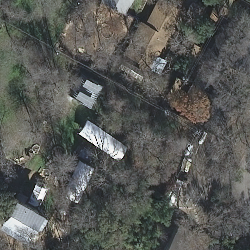

In [9]:
images_X[10]

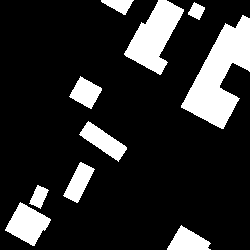

In [10]:
images_y[10]

In [11]:
X.shape

(1200, 160, 160, 3)

In [12]:
y.shape

(1200, 160, 160, 1)

# Model Set Up

Convolution block - used to perform the primary operation of taking the entered input parameters and processing a double layer of convolution operations. 

In [13]:
def convolution_operation(entered_input, filters=64):
  # Taking first input and implementing the first conv block
  conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
  batch_norm1 = BatchNormalization()(conv1)
  act1 = ReLU()(batch_norm1)
  
  # Taking first input and implementing the second conv block
  conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
  batch_norm2 = BatchNormalization()(conv2)
  act2 = ReLU()(batch_norm2)

### 
# padding = 'same' to maintain the same shapes
  
  return act2


**Constructing the encoder**
- use consecutive inputs starting from the first layer all the way to the bottom
- will use the convolution_operation (two conv2d layers, 2 batch norms and 2 ReLU activations)
- downsample the response of convolution_operation
- use max pooling 
- return initial output and the max-pooled output (used for performing skip connections)

In [14]:
def encoder(entered_input, filters=64):
  # Collect the start and end of each sub-block for normal pass and skip connections
  enc1 = convolution_operation(entered_input, filters)
  MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
  return enc1, MaxPool1

**Constructing the decoder**
- include three arguments (recieving inputs, input of skip connection, number of filters)
- upsamples the entered input with help of Conv2DTranspose layers 
- concatenate both receiving input and newly upsampled layers and receive value of skip connections
- use combined function and perform convolutional block operation to proceed to next layer and return output value

In [15]:
def decoder(entered_input, skip, filters=64):
  # Upsampling and concatenating the essential features
  Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
  Connect_Skip = Concatenate()([Upsample, skip])
  out = convolution_operation(Connect_Skip, filters)
  return out

**Constructing the U-Net architecture**
- use the input layer which will contain the respective shapes of our input image
- collect primary outputs and the skip outputs to pass them onto further blocks 
- create the next block and construct the entire decoder architecture until we reach output 
- output will have required dimensions according to our desired output
- call functional API modelling system to create final model and return this model to the user for performing tasks

In [16]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

#**Finalizing the Model:**
- ensure the image shapes are divisilbe by at least 16 or multiples of 16
  - since we are using four max-pooling laters during the down-sampling procedure we dont want to encounter the divisibility of any odd number shapes


In [17]:
X.shape[1:]

(160, 160, 3)

In [18]:
keras.backend.clear_session()

input_shape = X.shape[1:] # (160, 160, 3)
model = U_Net(input_shape)
model_iou = U_Net(input_shape)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

**Binary CrossEntropy Loss**

In [19]:
# opt = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',
                optimizer='adam')

In [20]:
# plot_model(model, 'model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

**IoU Loss**

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras import backend

In [22]:
def jacard_coef(y_true, y_pred):
  y_true_f = backend.flatten(y_true)
  y_pred_f = backend.flatten(y_pred)
  intersection = backend.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (backend.sum(y_true_f) + backend.sum(y_pred_f) - intersection + 1.0)

In [23]:
def jacard_coef_loss(y_true, y_pred):
  return -jacard_coef(y_true, y_pred) # - to minimise the loss

In [24]:
model_iou.compile(loss=[jacard_coef_loss], metrics=[jacard_coef], optimizer='adam')

# Model Training 

## Normalise input array DONE ON LOADING

In [25]:
X[:].shape

(1200, 160, 160, 3)

In [26]:
np.max(X[:,:,:,:])

1.0

## Spliting into test and train:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=5)

In [28]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (1080, 160, 160, 3)
X_test:  (120, 160, 160, 3)


## Trainning model

In [45]:
es = EarlyStopping(patience=5, restore_best_weights=True)
mc = ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.3,
                    batch_size=8, epochs=15,
                    callbacks=[mc])

Epoch 1/15
95/95 [==============================] - 31s 298ms/step - loss: 0.3369 - val_loss: 0.9701
Epoch 2/15
95/95 [==============================] - 26s 269ms/step - loss: 0.2513 - val_loss: 1.1886
Epoch 3/15
95/95 [==============================] - 25s 260ms/step - loss: 0.2258 - val_loss: 0.9904
Epoch 4/15
95/95 [==============================] - 26s 272ms/step - loss: 0.2087 - val_loss: 0.6140
Epoch 5/15
95/95 [==============================] - 25s 264ms/step - loss: 0.1962 - val_loss: 0.6382
Epoch 6/15
95/95 [==============================] - 28s 296ms/step - loss: 0.1881 - val_loss: 0.3948
Epoch 7/15
95/95 [==============================] - 28s 293ms/step - loss: 0.1893 - val_loss: 0.2301
Epoch 8/15
95/95 [==============================] - 27s 283ms/step - loss: 0.1652 - val_loss: 0.3242
Epoch 9/15
95/95 [==============================] - 26s 276ms/step - loss: 0.1656 - val_loss: 0.2244
Epoch 10/15
95/95 [==============================] - 27s 283ms/step - loss: 0.1658 - val_lo

**Using IoU Loss Metrics**

In [30]:
history_iou = model_iou.fit(X_train, y_train, validation_split=0.3,
                    batch_size=8, epochs=15,
                    callbacks=[mc])

Epoch 1/15
95/95 [==============================] - 39s 319ms/step - loss: -0.4158 - jacard_coef: 0.4157 - val_loss: -2.4166e-04 - val_jacard_coef: 2.4190e-04
Epoch 2/15
95/95 [==============================] - 27s 281ms/step - loss: -0.5337 - jacard_coef: 0.5349 - val_loss: -2.6443e-04 - val_jacard_coef: 2.6467e-04
Epoch 3/15
95/95 [==============================] - 28s 293ms/step - loss: -0.5700 - jacard_coef: 0.5698 - val_loss: -0.2379 - val_jacard_coef: 0.2372
Epoch 4/15
95/95 [==============================] - 26s 272ms/step - loss: -0.5947 - jacard_coef: 0.5937 - val_loss: -0.3208 - val_jacard_coef: 0.3194
Epoch 5/15
95/95 [==============================] - 27s 286ms/step - loss: -0.5942 - jacard_coef: 0.5947 - val_loss: -0.0379 - val_jacard_coef: 0.0386
Epoch 6/15
95/95 [==============================] - 28s 291ms/step - loss: -0.6159 - jacard_coef: 0.6161 - val_loss: -0.6125 - val_jacard_coef: 0.6118
Epoch 7/15
95/95 [==============================] - 27s 282ms/step - loss: -0.

# Plotting functions

In [31]:
import matplotlib.pyplot as plt
import random

In [32]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    # ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['jacard_coef'], label='train jacard_coef'  + exp_name)
    ax2.plot(history.history['val_jacard_coef'], label='val val_jacard_coef'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('IoU')
    ax2.legend()
    return (ax1, ax2)

In [50]:
def plot_comparison(X_true, y_true, y_pred, a=0, b=1, c=2):
  f, axs = plt.subplots(3, 3, figsize=(12, 12))
  titles = ['Test Image', 'Test Label', 'Prediction Label',
            'Test Image', 'Test Label', 'Prediction Label',
            'Test Image', 'Test Label', 'Prediction Label'
            ]
  

  ax1, ax2, ax3 = axs[0,0], axs[0,1], axs[0,2]
  ax4, ax5, ax6 = axs[1,0], axs[1,1], axs[1,2]
  ax7, ax8, ax9 = axs[2,0], axs[2,1], axs[2,2]

  idx = random.sample(range(0, X_test[:,:,:,:].shape[0]), 3)

  ax1.imshow(X_true[a,:,:,:])
  ax2.imshow(y_true[a,:,:,0])
  ax3.imshow(y_pred[a,:,:,0])

  ax4.imshow(X_true[b,:,:,:])
  ax5.imshow(y_true[b,:,:,0])
  ax6.imshow(y_pred[b,:,:,0])

  ax7.imshow(X_true[c,:,:,:])
  ax8.imshow(y_true[c,:,:,0])
  ax9.imshow(y_pred[c,:,:,0])

  # return axs

In [34]:
# plot_history(history, title='Trained U-Net')

# Predicting using model

Creating three random indexes to display images for both loss metrics.

In [46]:
idx = random.sample(range(0, X_test[:,:,:,:].shape[0]), 3)
a, b, c = idx[0], idx[1], idx[2]

##**Binary cross entropy**

In [47]:
y_pred = model.predict(X_test) # y_true = y_test[1:]

In [48]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 215ms/step - loss: 0.3405


0.34048816561698914

In [37]:
# plot_history(history)

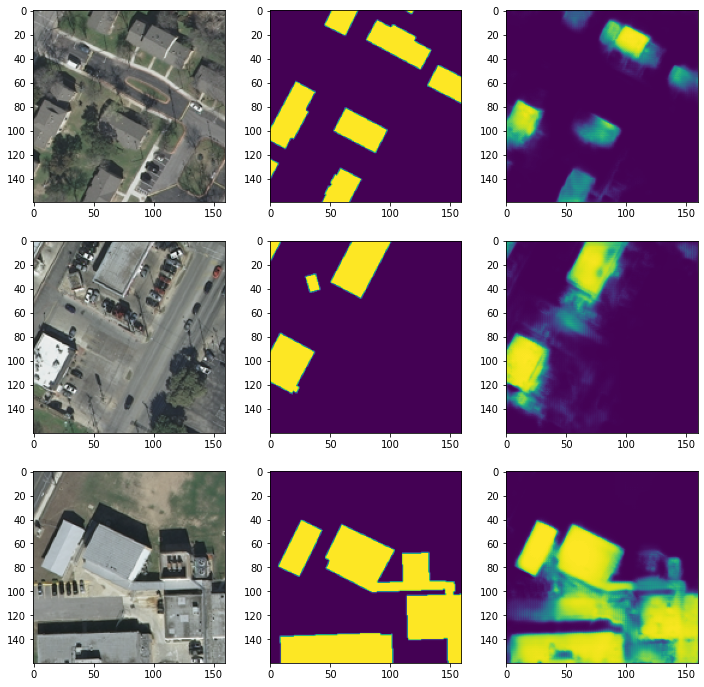

In [51]:
plot_comparison(X_test, y_test, y_pred, a, b, c)

##**IoU Prediction**

In [39]:
y_pred_iou = model_iou.predict(X_test) # y_true = y_test[1:]

In [40]:
model_iou.evaluate(X_test, y_test)

4/4 [==============================] - 1s 220ms/step - loss: -0.6795 - jacard_coef: 0.6759


[-0.6794849634170532, 0.6759035587310791]

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc946056250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc9460bca10>)

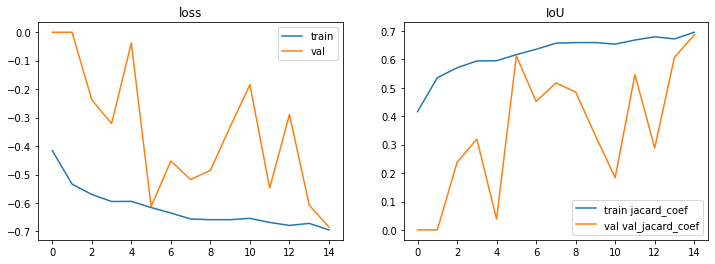

In [41]:
plot_history(history_iou, a, b, c)

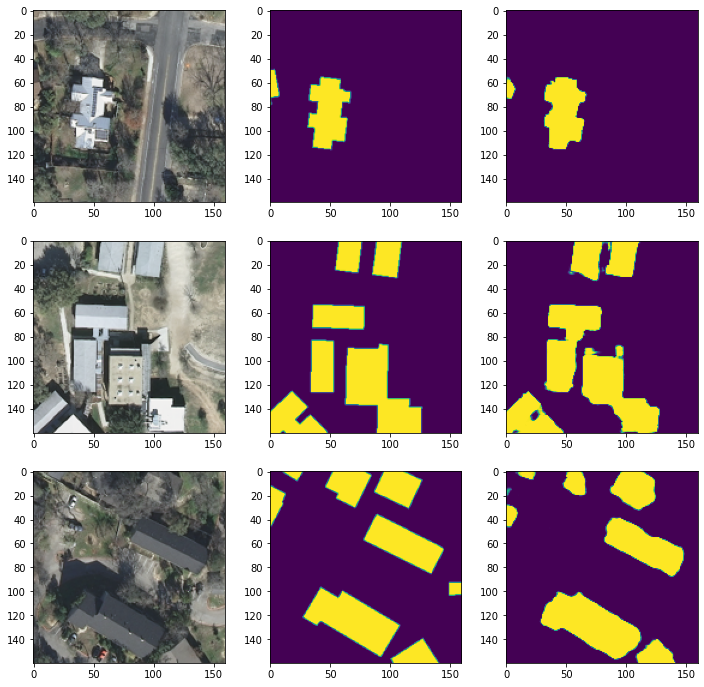

In [52]:
plot_comparison(X_test, y_test, y_pred_iou)

In [43]:
X_test[:,:,:,:].shape[0]

120

In [44]:
random.sample(range(0, X_test[:,:,:,:].shape[0]), 3)

[60, 40, 63]